In [1]:
from __future__ import print_function
import struct
import numpy as np
import math
import sys
import ROOT
import array
import matplotlib.pyplot as plt

import matplotlib.pylab as pltt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse,Arrow
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import matplotlib
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 36}
matplotlib.rc('font', **font)
import matplotlib.font_manager as font_manager


Welcome to JupyROOT 6.24/06


### Commond abbreviation and conversion equations:

| nuc | Nuclear mass (u) | Mass excess (keV) | Binding energy (/A) keV | Atomic mass (u) |
|:---|:-----------------:|:-----------------------:|:---------------:|:---------------:|
|  | $\mathrm{M_{n}(A,Z)}$ | $\mathrm{ME_{n}(A,Z)}$ | $\mathrm{B_{n}(A,Z)}$ | $\mathrm{M_{a}(A,Z)}$ | 
| n  | x | 8071.31806      | 0 | 1.00866491590 |
| 13C6  | x | 3125.00933   | 7469.8495 | 13.00335483534 |
| 16O8  | x | -4737.00217   | 7976.2072 | 15.99491461926 |

13 003354.83534

- 1 a.m.u unit (physics.nist.gov CODATA and AME2022):

$$
u_{1} = 931494.10242 \pm 0.00028 \;keV
$$


- Atomic unit to keV conversion:

$$
\mathrm{M_{n}(A,Z)} (in\;keV) = u_{1} \times  \mathrm{M_{n}(A,Z)} (in\;u)
$$

- Mass excess from atomic mass $M_{a}(A,Z)$ (in u):
$$
ME_{a}(A,Z) (in\;keV) = u_{1} \times (M_{a}(A,Z) (in\;u) - A)
$$

- Nuclear mass from atomic mass $M_{a}(A,Z)$ (in u):

$$
M_{n}(A,Z) = M_{a}(A,Z) - Z \times m_{e} + B_{e}(Z)
$$

with
$$
B_{e}(Z) = (14.4381 Z^{2.39} + 1.55468 \times 10^{-6} Z^{5.35})\times 10^{-3} / u_{1}\;u
$$

and
$$
m_{e} = (510.99895000 \pm 0.000000015) / u_{1} \;u
$$

- Binding energy per nucleon from atomic mass  \$M_{a}(A,Z)$ (in u):

$$
B(A,Z)/A (in\;keV) = 1/A[Z \times ME_{a}(^{1}H) + N \times ME_{a}(neutron) - ME_{a}(A,Z)]
$$

with
$$
ME(^{1}H) = 1.007825031898 \pm 0.000000000473 \;u
$$

and

$$
ME(neutron) = 1.008664915904 \pm 0.000000000014 \;u
$$



## For FRDM+QRPA 2012

[Möller, P., Sierk, A. J., Ichikawa, T., & Sagawa, H. (2016). Nuclear ground-state masses and deformations: FRDM (2012). Atomic Data and Nuclear Data Tables, 109, 1-204.](https://doi.org/10.1016/j.adt.2015.10.002)


$$
M_{n}(A,Z) = M_{a}(A,Z) - Z \times m_{e} + a_{el} \times Z^{2.39}
$$

$$
a_{el}= 0.01433\;keV
$$


$$
m_{e}= 510.99906\;keV
$$

$$
E_{bind}(Z,N) = ZM_{n}(proton) + NM_{n}(neutron) - M_{n}(Z,N) = Z(ME_{H}+1 - m_{e}+a_{el})+N(ME_{H}+1)-(ME_{n}(Z,N)+Z+N)
$$

$$
1\;u = 931501.4\;keV
$$

$$
ME_{H} = 7289.034\;keV = 7289.034/931501.4\;u
$$


$$
ME_{n} = 8071.431\;keV = 8071.431/931501.4\;u
$$

- Example of the FRDM prediction:

$$
M_{th}(^{16}O) = -5.15\;MeV 
$$

$$
E_{bind (th)}(^{16}O) = 128.03\;MeV 
$$

In [2]:
u1 = 931494.10242
def amass_to_nmass_keV(amass,Z):
    u1 = 931494.10242
    meu = 0.000548579909065
    meKeV = 510.99895000
    Be = (14.4381*(Z**2.39)+1.55468e-6*(Z**5.35))*1e-3
    nmass = amass*u1-Z*meKeV+Be*Z
    return nmass

def amass_to_mass_excess_keV(amass,A):
    u1 = 931494.10242
    return (amass - A)*u1

def amass_to_binding_ene_per_A_keV_way1(amass,Z,A):
    u1 = 931494.10242
    neumass = 1.008664915904
    pmass =   1.007276466588
    return (neumass*(A-Z) + pmass*Z - amass_to_nmass_keV(amass,Z)/u1)*u1/A

def amass_to_binding_ene_per_A_keV(amass,Z,A):
    u1 = 931494.10242
    neumass = 1.008664915904
    h1mass = 1.007825031898
    return (neumass*(A-Z) + h1mass*Z - amass)*u1/A

def FRDM_massecess_keV_to_binding_ene_keV(massexcess,Z,A):
    u1 = 931501.4
    me_H = 7.289034e3
    me_n = 8.071431e3
    melectron = 510.99906
    ael = 1.433e-2
    return ((me_n/u1+1)*(A-Z)*u1 + (me_H/u1+1-melectron/u1+ael/u1)*Z*u1 - (massexcess+A*u1 - Z*melectron+ael*Z**2.39) )


def mass_excess_keV_to_amass(mass_excess,A):
    u1 = 931494.10242
    return mass_excess/u1 + A


In [3]:
print(amass_to_mass_excess_keV(1.00866491590,1))

8071.318058815352


In [4]:
print(amass_to_mass_excess_keV(13.00335483534,13))

3125.009333799912


In [5]:
print(mass_excess_keV_to_amass(3125.009333799912,13))

13.00335483534


In [6]:
print(amass_to_binding_ene_per_A_keV(13.00335483534,6,13))

7469.849499184584


In [7]:
print(amass_to_mass_excess_keV(15.99491461926,16))

-4737.002167870856


In [8]:
print(amass_to_binding_ene_per_A_keV(15.99491461926,8,16))

7976.207198880236


In [9]:
print(FRDM_massecess_keV_to_binding_ene_keV(-5150,8,16))

128031.77101272531


### AME mass table 2020

In [10]:
ame = np.load("ame/all_ame20.npy",allow_pickle='TRUE')

In [11]:
for idx,i in enumerate(ame):
    if (i["A"]==90 and i["Z"]==38):
        mass_amu = i["A2"]+i["AM"]*1e-6
        dmass_amu = i["DAM"]*1e-6
        print(mass_amu,dmass_amu,amass_to_mass_excess_keV(i["A2"]+i["AM"]*1e-6,i["A"]),dmass_amu*u1,i["M"],i["DM"])

89.90772787 1.555e-06 -85950.9449127295 1.4484733292631 -85950.945 1.449


# TOF to mass conversion

- Observe TOF as a function of masses:

$$
t_{obs} = (a+b\cdot l) (m/q)^{1/2} +t_{0}
$$

where: $a$ and $b$ are constants related to non-reflection and flight path in MRTOF, $l$ is the *number of laps*,  **$m$ is the ionic mass** and $t_{0}$ is the TOF offset.

## Double referencing:

- Assuming we have two reference ion species (1,2) and one measured ion species:

(1):
$$
t_{1} = (a+b\cdot l) (m_{1}/q_{1})^{1/2} +t_{0}
$$

(2):
$$
t_{2} = (a+b\cdot l) (m_{2}/q_{2})^{1/2} +t_{0}
$$

(3):
$$
t = (a+b\cdot l) (m/q)^{1/2} +t_{0}
$$

- $2 \times (3) - (1) - (2)$  gives (4):

$$
2t-t_{1}-t_{2} = (a+b\cdot l)[2(m/q)^{1/2}-(m_{1}/q_{1})^{1/2}-(m_{2}/q_{2})^{1/2}]
$$

- $(1) - (2)$  gives (5):

$$
t_{1}-t_{2} = (a+b\cdot l)[(m_{1}/q_{1})^{1/2}-(m_{2}/q_{2})^{1/2}]
$$

- Or (6):

$$
(a+b\cdot l) = (t_{1}-t_{2}) / [(m_{1}/q_{1})^{1/2}-(m_{2}/q_{2})^{1/2}]
$$

- Combine (4) and (6) gives (7):


$$
\frac{2t-t_{1}-t_{2}}{(t_{1}-t_{2})} =  \frac{2(m/q)^{1/2}-(m_{1}/q_{1})^{1/2}-(m_{2}/q_{2})^{1/2}}{(m_{1}/q_{1})^{1/2}-(m_{2}/q_{2})^{1/2}}
$$

- Or (8): 

$$
C_{TOF} = \frac{2t-t_{1}-t_{2}}{2(t_{1}-t_{2})} =  \frac{(m/q)^{1/2}-[(m_{1}/q_{1})^{1/2}+(m_{2}/q_{2})^{1/2}]/2}{(m_{1}/q_{1})^{1/2}-(m_{2}/q_{2})^{1/2}}
$$



- Then (9):

$$
 (m/q)^{1/2} = C_{TOF}[(m_{1}/q_{1})^{1/2}-(m_{2}/q_{2})^{1/2}]+[(m_{1}/q_{1})^{1/2}+(m_{2}/q_{2})^{1/2}]/2
$$


## Single referencing:

- Assuming we have one reference ion species (ref) and one measured ion species:

(10):
$$
t_{ref} - t_{0} = (a+b\cdot l) (m_{ref}/q_{ref})^{1/2}
$$

(11):
$$
t - t_{0} = (a+b\cdot l) (m/q)^{1/2}
$$

- $(11)/(10)$ gives (12):
$$
\frac{t - t_{0}}{t_{ref} - t_{0}} = \frac{(m/q)^{1/2}}{(m_{ref}/q_{ref})^{1/2}}
$$

- Or (13):
$$
(m/q) = \left (\frac{t - t_{0}}{t_{ref} - t_{0}} \right )^{2} (m_{ref}/q_{ref})
$$



## Summary for a simplied scenario: Asssuming reference ions and measured ions have same charge states

- ### Single referencing:
$$
m = \left (\frac{t - t_{0}}{t_{ref} - t_{0}} \right )^{2} m_{ref}
$$

- ### Double referencing:
$$
m = \left ( C_{TOF}(m_{1}^{1/2}-m_{2}^{1/2})+(m_{1}^{1/2}+m_{2}^{1/2})/2 \right )^{2}
$$
where
$$
C_{TOF} = \frac{2t-t_{1}-t_{2}}{2(t_{1}-t_{2})}
$$

- Note that **$m$ is the ionic mass** for reference and measured ions. We need to derive it from the atomic mass having electrons (how about binding energy of electron?)

$$
M = m + q \times m_{e}
$$

$$
m_{ref} = M_{ref} - q \times m_{e}
$$

$$
m_{1} = M_{1}  -q \times m_{e}
$$

$$
m_{2} = M_{2} - q \times m_{e}
$$

Where: 

- $M_{ref}$, $M_{1}$ and $M_{2}$ is the atomic mass of the reference ion species, taken from latest AME database (AME2020) in a.m.u

- $m_{e}$ is the electron rest mass, taken from latest AME database (AME2020) in a.m.u as:
$$
m_{e} = 548579.909065 \times 10^{-9} \pm 0.000016 \times 10^{-9} \;u
$$

- Or alternatively:
$$
m_{e} = (510.99895000 \pm 0.000000015) / u_{1} \;u
$$

$$
u_{1} = 931494.10242 \pm 0.00028 \;keV
$$

In [21]:
np.log(2)

0.6931471805599453

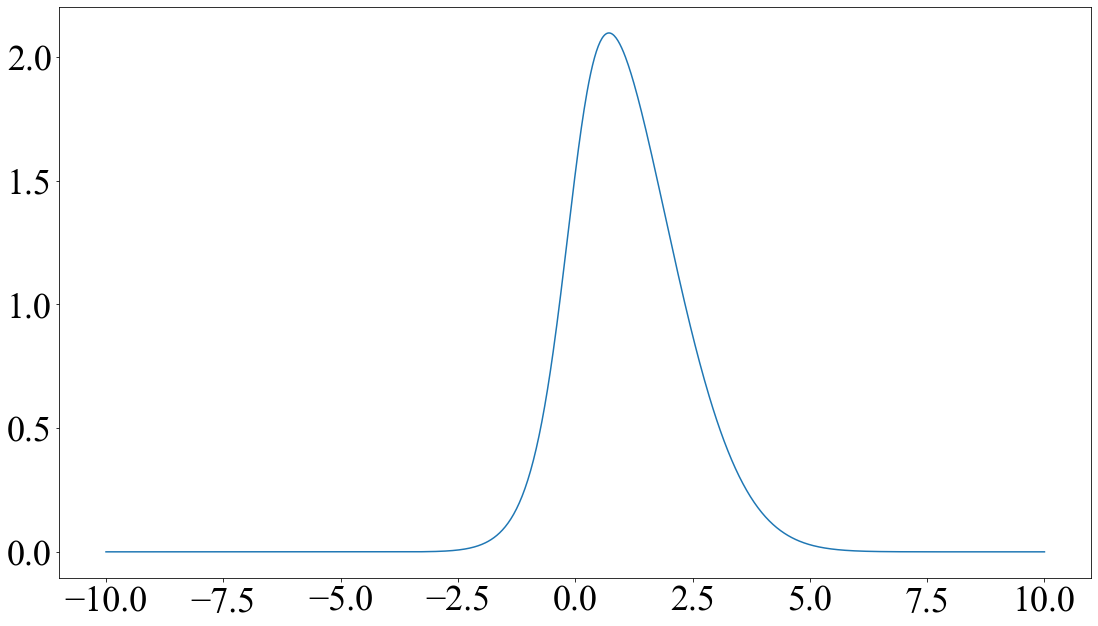

In [27]:

x = np.linspace(-10,10,1000)
mu = 1.1
w = 1.5
s = 2.
k = 1.
y = 1./np.sqrt(x*x+1) * np.exp(-0.5*(x-mu)*(x-mu)/w/w)* (s+k*np.log(x+np.sqrt(x*x+1)))

fig,axis = plt.subplots()
fig.set_size_inches(18.5,10.5)
fig.subplots_adjust(hspace=0,wspace=0)
axis.plot(x,y)
# axis.set_xlim([10600,11000])

In [29]:
9200+300*10

12200

0.5